In [1]:
# https://medium.com/@redeaddiscolll/prediction-of-stock-prices-using-lstm-dcd54033c2f1

import pandas as pd
import numpy as np
import matplotlib as mpl

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
stk = pd.read_csv("TSLA_1Y.csv")
# stk = stock.get_market_ohlcv("20180101", "20220731", "005930")
stk.head()



,Date,Open,High,Low,Close,Volume
0,09/01/2023,257.26,259.08,242.01,245.01,"132,541,594"
1,08/31/2023,255.98,261.18,255.05,258.08,"108,861,695"
2,08/30/2023,254.20,260.51,250.59,256.90,"121,988,398"
3,08/29/2023,238.58,257.48,237.77,257.18,"134,047,594"
4,08/28/2023,242.58,244.38,235.35,238.82,"107,673,695"


In [3]:
to_drop = ['High', 'Low', 'Volume']
stk.drop(columns=to_drop, inplace=True, axis=1)
stk['Date'] = pd.to_datetime(stk['Date'])
stk.set_index('Date', drop=True, inplace=True)

stk.head()



,Open,Close
Date,,
2023-09-01,257.26,245.01
2023-08-31,255.98,258.08
2023-08-30,254.20,256.90
2023-08-29,238.58,257.18
2023-08-28,242.58,238.82


<bound method Figure.show of <Figure size 2000x700 with 2 Axes>>

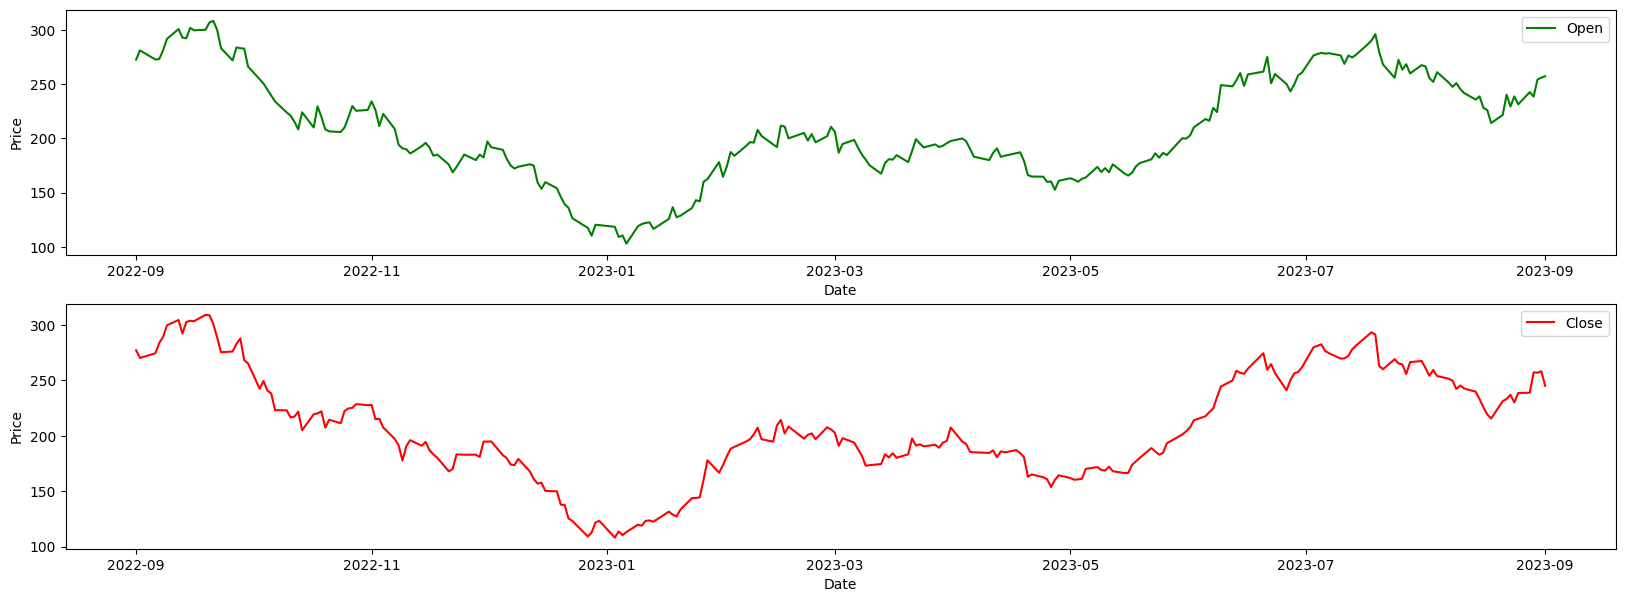

In [4]:
# 시가 : green / 종가 : red

fig, ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(stk['Open'], label='Open', color='green')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].legend()
ax[1].plot(stk['Close'], label='Close', color='red')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')
ax[1].legend()
fig.show

In [5]:
# 데이터 전처리
MS = MinMaxScaler()
stk[stk.columns] = MS.fit_transform(stk)
stk.head() 

,Open,Close
Date,,
2023-09-01,0.751425,0.681246
2023-08-31,0.745190,0.746281
2023-08-30,0.736519,0.740409
2023-08-29,0.660432,0.741802
2023-08-28,0.679916,0.650445


In [6]:
# 훈련과 테스트 간의 데이터 분할

training_size = round(len(stk)*0.80)
train_data = stk[:training_size]
test_data = stk[training_size:]

def create_sequence(dataset):
    sequences = []
    labels = []
    start_idx = 0
    for stop_idx in range(5, len(dataset)):
        sequences.append(dataset.iloc[start_idx:stop_idx])
        labels.append(dataset.iloc[stop_idx])
        start_idx += 1
    return (np.array(sequences), np.array(labels))

train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [7]:
# LSTM 모델 구현

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1))
model.add(LSTM(units=100))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'accuracy'])

model.summary()







Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10600     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 71202 (278.13 KB)
Trainable params: 71202 (278.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.fit(train_seq, train_label, epochs=1200, validation_data=(test_seq,test_label),verbose=1)
test_predicted = model.predict(test_seq)
test_inverse_predicted = MS.inverse_transform(test_predicted)


# 실제 레이블 데이터 (실제 주식 가격)
test_actual = MS.inverse_transform(test_label)

# 평균 제곱 오차 (MSE) 계산
mse = mean_squared_error(test_actual, test_inverse_predicted)
print("Mean Squared Error (MSE):", mse)

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(test_actual, test_inverse_predicted)
print("Mean Absolute Error (MAE):", mae)

Epoch 1/1200
7/7 [==============================] - 1s 55ms/step - loss: 0.1911 - mean_absolute_error: 0.3868 - accuracy: 0.6904 - val_loss: 0.2304 - val_mean_absolute_error: 0.4630 - val_accuracy: 0.5333
Epoch 2/1200
7/7 [==============================] - 0s 5ms/step - loss: 0.0455 - mean_absolute_error: 0.1670 - accuracy: 0.4315 - val_loss: 0.0055 - val_mean_absolute_error: 0.0617 - val_accuracy: 0.4667
Epoch 3/1200
7/7 [==============================] - 0s 5ms/step - loss: 0.0231 - mean_absolute_error: 0.1366 - accuracy: 0.4670 - val_loss: 0.0056 - val_mean_absolute_error: 0.0610 - val_accuracy: 0.5333
Epoch 4/1200
7/7 [==============================] - 0s 5ms/step - loss: 0.0088 - mean_absolute_error: 0.0748 - accuracy: 0.7005 - val_loss: 0.0379 - val_mean_absolute_error: 0.1759 - val_accuracy: 0.5333
Epoch 5/1200
7/7 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_absolute_error: 0.0795 - accuracy: 0.5533 - val_loss: 0.0189 - val_mean_absolute_error: 0.1179 - 

In [9]:
# stk_slic_data = pd.concat([stk.iloc[-242:].copy(), pd.DataFrame(test_inverse_predicted, columns=['Open_predicted','Close_predicted'], index=stk.iloc[-242:].index)],axis=1)
# stk_slic_data[['Open',"Close"]]  = MS.inverse_transform(stk_slic_data[['Open',"Close"]] )
# stk_slic_data.head()

# 'stk.iloc[-242:].copy()' 데이터프레임의 마지막 45개 행 선택
stk_subset = stk.iloc[-45:].copy()

# 'test_inverse_predicted'를 DataFrame으로 변환
test_inverse_predicted_df = pd.DataFrame(test_inverse_predicted, columns=['Open_predicted', 'Close_predicted'])

# 'test_inverse_predicted_df' 데이터프레임의 인덱스를 'stk_subset'과 일치시킴
test_inverse_predicted_df.index = stk_subset.index

# 두 데이터프레임을 합침
stk_slic_data = pd.concat([stk_subset, test_inverse_predicted_df], axis=1)

# 열의 수가 일치하므로 합친 후에 다음 작업을 수행
stk_slic_data[['Open', 'Close']] = MS.inverse_transform(stk_slic_data[['Open', 'Close']])
stk_slic_data.head()





,Open,Close,Open_predicted,Close_predicted
Date,,,,
2022-11-03,211.36,215.31,221.408569,223.082764
2022-11-02,226.04,214.98,214.988129,213.428513
2022-11-01,234.05,227.82,224.755142,225.768860
2022-10-31,226.19,227.54,234.821945,236.049667
2022-10-28,225.40,228.52,228.439957,227.403931


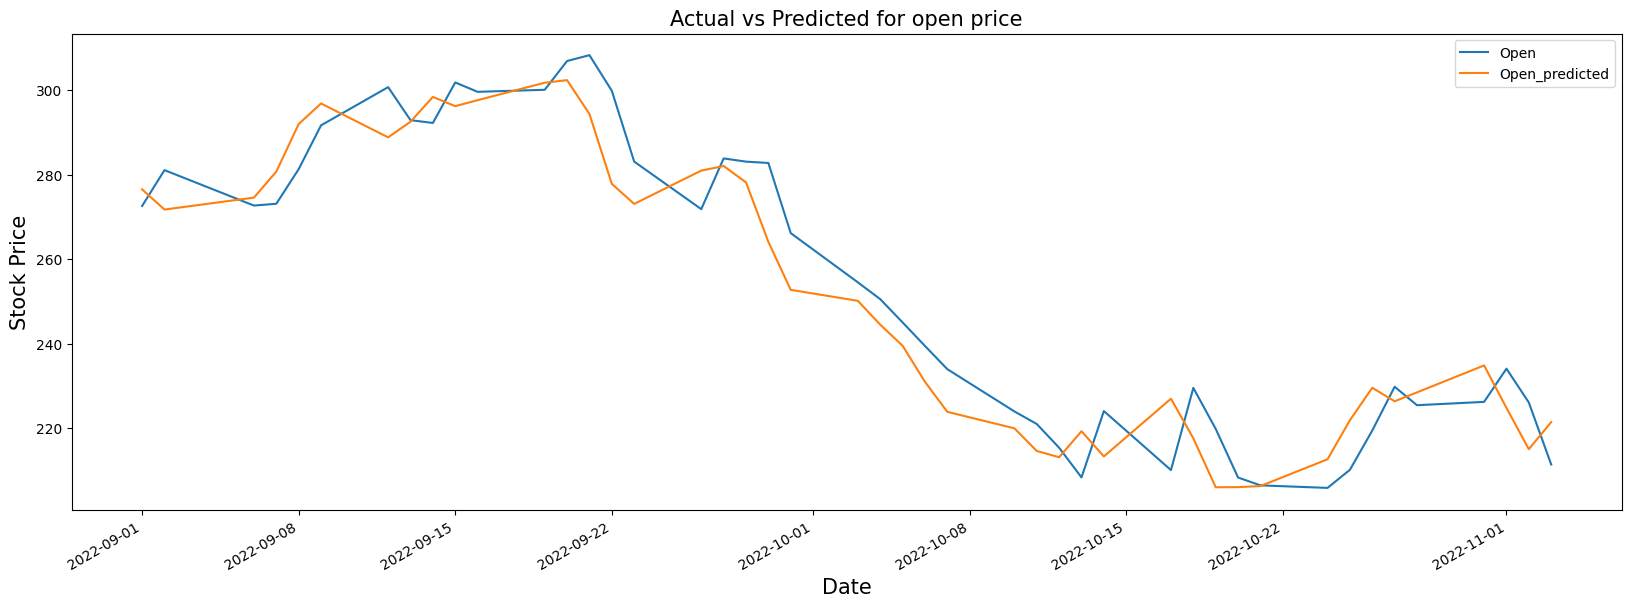

In [10]:
stk_slic_data[['Open','Open_predicted']].plot(figsize=(20,7))

plt.xticks(rotation=30)

plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()



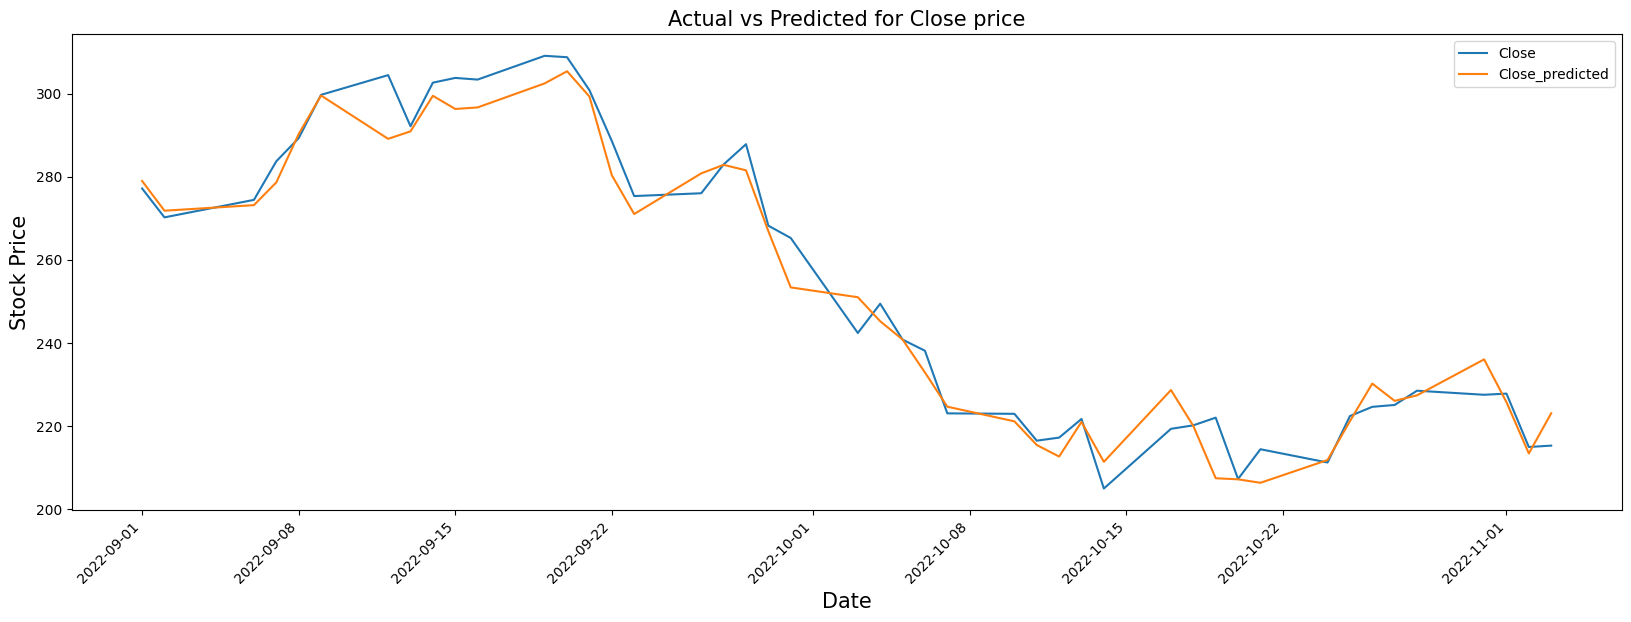

In [11]:
stk_slic_data[['Close','Close_predicted']].plot(figsize=(20,7))

plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for Close price',size=15)
plt.show()

